In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np

In [2]:
train_df = pd.read_csv("recent/train.csv")
val_df = pd.read_csv("recent/val.csv")

train_df["image:FILE"] = "recent/" + train_df["image:FILE"]
val_df["image:FILE"] = "recent/" + val_df["image:FILE"]

In [3]:
print("train data shape:" ,train_df.shape)
print("validation data shape:" ,val_df.shape)

train data shape: (1034, 2)
validation data shape: (133, 2)


In [4]:
train_df.sample(3)

,image:FILE,category
997,recent/train/bean_rust/bean_rust_train.259.jpg,2
376,recent/train/angular_leaf_spot/angular_leaf_sp...,1
173,recent/train/healthy/healthy_train.142.jpg,0


In [5]:
train_df["category"].value_counts()

category
2    348
1    345
0    341
Name: count, dtype: int64

In [6]:
# transforming to make sure all become same

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [7]:
class MyImageData(Dataset):
    def __init__(self,dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(dataframe["category"])
        
    def __len__(self):
        return self.dataframe.shape[0]
        
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)/255.0
        return image, label

In [8]:
train_dataset = MyImageData(dataframe=train_df, transform=transform)
val_dataset = MyImageData(dataframe=val_df, transform=transform)

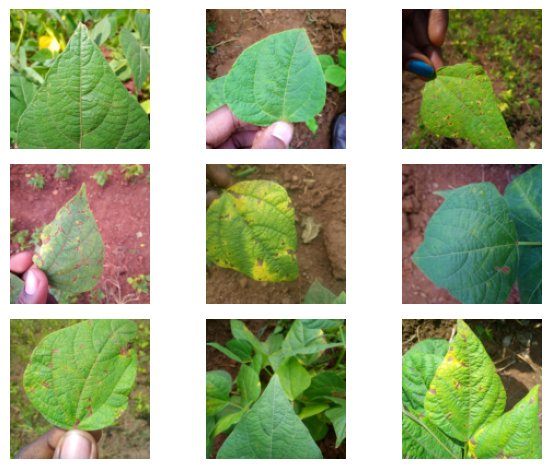

In [9]:
n_rows = 3
n_cols = 3
f, ax = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = train_dataset[np.random.randint(0, train_dataset.__len__())][0]
        ax[row, col].imshow((image*255.0).squeeze().permute(1,2,0))
        ax[row, col].axis("off")

plt.tight_layout()
plt.show()

In [10]:
lr = 1e-3
batch_size = 4
epochs = 10

In [11]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [12]:
googlenet_model = models.googlenet(weights="DEFAULT")

In [13]:
for param in googlenet_model.parameters():
    param.requires_grad = True              #tells the model for its parameters to learn again

In [14]:
googlenet_model.fc   #checking the last layer, we can see it has 1000 class for classification

Linear(in_features=1024, out_features=1000, bias=True)

In [15]:
num_classes = len(train_df['category'].unique())    #checking how many classes do we have
num_classes

3

In [16]:
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.fc          #changing the output classes to 3 as we have it

Linear(in_features=1024, out_features=3, bias=True)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr=lr)

total_train_loss_plot = []
total_train_acc_plot = []

for epoch in range(epochs):
    total_acc_train=0
    total_loss_train=0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs= googlenet_model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()
        train_loss.backward()
        train_acc  = (torch.argmax(outputs, axis =1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

total_train_loss_plot.append(round(total_loss_train/1000, 4))
total_train_acc_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))

print(f'Epoch {epoch+1}/{epochs}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}%')
print()